<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Readability Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the readability or unreadability of code generated by LLM applications.

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to classifying
  generated code as readable or unreadable using datasets with ground-truth
  labels
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [45]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 10

In [46]:
!pip install -qq "arize-phoenix[experimental]" "openai>1" ipython matplotlib pycm scikit-learn tiktoken

In [47]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.experimental.evals import (
    CODE_READABILITY_PROMPT_RAILS_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE_STR,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in
addition to an evaluation prompt template against a benchmark datasets of
readable and unreadable code with ground-truth labels. Currently supported
datasets for this task include:

- openai_humaneval_with_readability

In [48]:
dataset_name = "openai_humaneval_with_readability"
df = download_benchmark_dataset(task="code-readability-classification", dataset_name=dataset_name)
df.head()

,Unnamed: 0,task_id,prompt,canonical_solution,test,entry_point,readable,solution
0,0,HumanEval/0,"from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n """""" Check if in given list of numbers, are any two numbers closer to each other than\n given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n True\n """"""\n","for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n","\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.95) == True\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.8) == False\n assert candidate([1.0, 2.0, 3.0, 4.0, 5.0, 2.0], 0.1) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 1.0) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 0.5) == False\n\n",has_close_elements,True,"for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n"
1,1,HumanEval/1,"from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n """""" Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n separate those group into separate strings and return the list of those.\n Separate groups are balanced (each open brace is properly closed) and not nested within each other\n Ignore any spaces in the input string.\n >>> separate_paren_groups('( ) (( )) (( )( ))')\n ['()', '(())', '(()())']\n """"""\n",result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate('(()()) ((())) () ((())()())') == [\n '(()())', '((()))', '()', '((())()())'\n ]\n assert candidate('() (()) ((())) (((())))') == [\n '()', '(())', '((()))', '(((())))'\n ]\n assert candidate('(()(())((())))') == [\n '(()(())((())))'\n ]\n assert candidate('( ) (( )) (( )( ))') == ['()', '(())', '(()())']\n",separate_paren_groups,True,result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n
2,2,HumanEval/2,"\n\ndef truncate_number(number: float) -> float:\n """""" Given a positive floating point number, it can be decomposed into\n and integer part (largest integer smaller than given number) and decimals\n (leftover part always smaller than 1).\n\n Return the decimal part of the number.\n >>> truncate_number(3.5)\n 0.5\n """"""\n",return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate(3.5) == 0.5\n assert abs(candidate(1.33) - 0.33) < 1e-6\n assert abs(candidate(123.456) - 0.456) < 1e-6\n",truncate_number,False,return((lambda x: (lambda y: y(x))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u)))))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u))))(lambda f: lambda x: x if x == 0 else f(x - 1) + 1)(number % 1.0))
3,3,HumanEval/3,"from typing import List\n\n\ndef below_zero(operations: List[int]) -> bool:\n """""" You're given a list of deposit and withdrawal operations on a ban

## Display Binary Readability Classification Template

View the default template used to classify readability. You can tweak this template and evaluate its performance relative to the default.

In [49]:
print(CODE_READABILITY_PROMPT_TEMPLATE_STR)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{query}
```

Implementation to Evaluate:
```
{code}
```



The template variables are:

- **query:** the coding task asked by a user
- **code:** implementation of the coding task

## Configure the LLM

Configure your OpenAI API key.

In [50]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

Instantiate the LLM and set parameters.

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [51]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df = df.rename(
    columns={"prompt": "query", "solution": "code"},
)

## LLM Evals: Code Readability Classifications GPT-4

Run readability classifications against a subset of the data.

In [52]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [53]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [54]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)["label"]

  0%|          | 0/10 [00:00<?, ?it/s]


Evaluate the predictions against human-labeled ground-truth readability labels.

              precision    recall  f1-score   support

    readable       0.83      0.71      0.77         7
  unreadable       0.50      0.67      0.57         3

    accuracy                           0.70        10
   macro avg       0.67      0.69      0.67        10
weighted avg       0.73      0.70      0.71        10



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

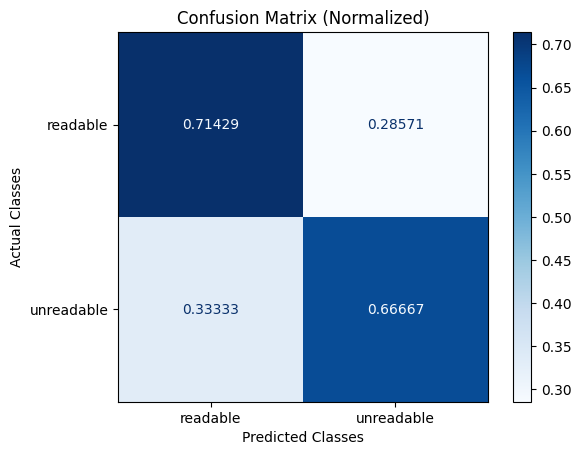

In [55]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()
readability_classifications = (
    pd.Series(readability_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows
where the evals deviated from ground truth and see what the actual code was in
that case.

In [56]:
df["readability"] = readability_classifications
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == False and readability == "readable"')

# inspect first 5 rows that meet this condition
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,query,canonical_solution,test,entry_point,readable,code,readability
1,29,HumanEval/29,"from typing import List\n\n\ndef filter_by_prefix(strings: List[str], prefix: str) -> List[str]:\n """""" Filter an input list of strings only for ones that start with a given prefix.\n >>> filter_by_prefix([], 'a')\n []\n >>> filter_by_prefix(['abc', 'bcd', 'cde', 'array'], 'a')\n ['abc', 'array']\n """"""\n",return [x for x in strings if x.startswith(prefix)]\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([], 'john') == []\n assert candidate(['xxx', 'asd', 'xxy', 'john doe', 'xxxAAA', 'xxx'], 'xxx') == ['xxx', 'xxxAAA', 'xxx']\n",filter_by_prefix,False,"return list(filter(lambda x: x[:len(prefix)] == prefix, strings))",readable


## Classifications with explanations

When evaluating a dataset for readability, it can be useful to know why the LLM classified text as readable or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [57]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
readability_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
)

OpenAI invocation parameters: {'model': 'gpt-4', 'temperature': 0.0, 'max_tokens': 256, 'frequency_penalty': 0, 'presence_penalty': 0, 'top_p': 1, 'n': 1, 'timeout': None}


  0%|          | 0/5 [00:00<?, ?it/s]

- Snapped 'unreadable' to rail: unreadable
- Snapped 'unreadable' to rail: unreadable
- Snapped 'readable' to rail: readable
- Snapped 'readable' to rail: readable
- Snapped 'unreadable' to rail: unreadable


In [58]:
# Let's view the data
merged_df = pd.merge(small_df_sample, readability_classifications_df, left_index=True, right_index=True)
merged_df[["query", "code", "label", "explanation"]].head()

,query,code,label,explanation
0,"\n\ndef common(l1: list, l2: list):\n """"""Return sorted unique common elements for two lists.\n >>> common([1, 4, 3, 34, 653, 2, 5], [5, 7, 1, 5, 9, 653, 121])\n [1, 5, 653]\n >>> common([5, 3, 2, 8], [3, 2])\n [2, 3]\n\n """"""\n",ret = set()\n for e1 in l1:\n for e2 in l2:\n if e1 == e2:\n ret.add(e1)\n return sorted(list(ret))\n,unreadable,"The code is unnecessarily complex for what it's trying to accomplish. It uses nested loops to find common elements between two lists, which is inefficient and makes the code harder to read. A simpler and more readable approach would be to convert the lists to sets and use the intersection method, then sort the result. This would accomplish the same task in a single line of code."
1,"\ndef solve(s):\n """"""You are given a string s.\n if s[i] is a letter, reverse its case from lower to upper or vise versa, \n otherwise keep it as it is.\n If the string contains no letters, reverse the string.\n The function should return the resulted string.\n Examples\n solve(""1234"") = ""4321""\n solve(""ab"") = ""AB""\n solve(""#a@C"") = ""#A@c""\n """"""\n","flg,idx,new_str,s=[0,0,list(s),""""]\nfor i in s:\n if i.isalpha():\n new_str[idx]=i.swapcase()\n flg=1\n idx+=1\nfor i in new_str:\n s+=i\nreturn s if flg else s[len(s)::-1]",unreadable,"The code is not readable due to the use of unclear variable names such as 'flg', 'idx', and 's'. It's also not immediately clear what the purpose of the 'flg' variable is. The code could be simplified and made more readable by using more descriptive variable names and by using built-in Python functions to reverse the string and swap cases."
2,"\ndef count_up_to(n):\n """"""Implement a function that takes an non-negative integer and returns an array of the first n\n integers that are prime numbers and less than n.\n for example:\n count_up_to(5) => [2,3]\n count_up_to(11) => [2,3,5,7]\n count_up_to(0) => []\n count_up_to(20) => [2,3,5,7,11,13,17,19]\n count_up_to(1) => []\n count_up_to(18) => [2,3,5,7,11,13,17]\n """"""\n","primes = []\n for i in range(2, n):\n is_prime = True\n for j in range(2, i):\n if i % j == 0:\n is_prime = False\n break\n if is_prime:\n primes.append(i)\n return primes\n\n",readable,"The code is simple and straightforward. It uses two nested loops to check if a number is prime by checking if it has any divisors other than 1 and itself. If it doesn't, it's added to the list of primes. The variable names are clear and the logic is easy to follow."
3,"\ndef can_arrange(arr):\n """"""Create a function which returns the largest index of an element which\n is not greater than or equal to the element immediately preceding it. If\n no such element exists then return -1. The given array will not contain\n duplicate values.\n\n Examples:\n can_arrange([1,2,4,3,5]) = 3\n can_arrange([1,2,3]) = -1\n """"""\n",ind=-1\n i=1\n while i<len(arr):\n if arr[i]<arr[i-1]:\n ind=i\n i+=1\n return ind\n,readable,"The code is simple and straightforward. It uses a while loop to iterate through the array and checks if the current element is less than the previous one. If it is, it updates the index. The variable names could be more descriptive, but overall, the logic is easy to follow."
4,"\ndef words_string(s):\n """"""\n You will be given a string of words separated by commas or spaces. Your task is\n to split the string into words and return an array of the words.\n \n For example:\n words_string(""Hi, my name is John"") == [""Hi"", ""my"", ""name"", ""is"", ""John""]\n words_string(""One, two, three, four, five, six"") == [""One"", ""two"", ""three"", ""four"", ""five"", ""six""]\n """"""\n","if not s:\n return []\n\n s_list = []\n\n for letter in s:\n if letter == ',':\n s_list.append(' ')\n else:\n s_list.append(letter)\n\n s_list = """".join(s_list)\n return s_list.split()\n",unreadable,"The code is unnecessarily complex for the task it's trying to accomplish. The task is to split a string into words, which can be done dire

## LLM Evals: Code Readability Classifications GPT-3.5

Run readability classifications against a subset of the data.

In [59]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20, max_retries=0),
    rails=rails,
)["label"]

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    readable       0.75      0.86      0.80         7
  unreadable       0.50      0.33      0.40         3

    accuracy                           0.70        10
   macro avg       0.62      0.60      0.60        10
weighted avg       0.68      0.70      0.68        10



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

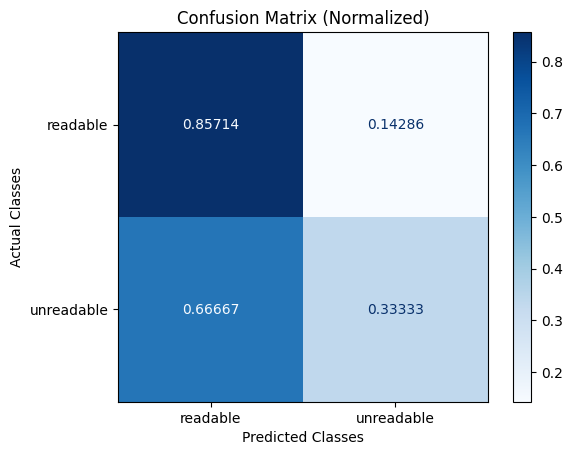

In [62]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()
readability_classifications = (
    pd.Series(readability_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

# Preview: GPT-4 Turbo

In [ ]:
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE_STR,
    model=OpenAIModel(model_name="gpt-4-1106-preview", temperature=0.0),
    rails=rails,
)["label"]

In [ ]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()
readability_classifications = (
    pd.Series(readability_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)